In [10]:
import pint
import numpy as np
import matplotlib.pyplot as plt
u = pint.UnitRegistry()
from scipy.integrate import solve_ivp

In [11]:
#define the parameters
T_a0 = 300 #* u.kelvin #initial temperature of the gas inside the cylinder
m_a0 = 0.003738313925588271 #* u.kilogram #initial mass of gas inside the cylinder
T_w0 = 305 #* u.kelvin #initial temperature of the cylinder walls
L = 0.2602992 #* u.ft #length of the cylinder
D = 0.067056 #* u.ft #diameter of the cylinder
A_s = np.pi * D * ( L + D / 2.0 ) #surface area of the walls of the tank
D_e = 0.002794 # * u.inch
A_e = np.pi * D_e **2 / 4.0
#A_e = 0.0001 * u.meter ** 2 #cross sectional area of the nozzle
A_c = np.pi* D ** 2 /4.0 #Area of the cylinder
V = A_c * L # volume inside the tank 
R_a = 287 #* u.joule / u.kilogram / u.kelvin #gas constant for gas
c_w = 1250 #* u.joule / u.kilogram / u.kelvin #specific heat of the tank wall material
g_c = 1 #proportionality appearing in Newton's second law 
g = 9.81 #* u.meter/u.second**2
J = 1 ### !!!!!!4186 * u.joule #joule's constant
rho_polycarbonate = 1200 # * u.gram / u.centimeter **3 
wall_thickness = 0.005 #* u.millimeter
m_w = rho_polycarbonate * (np.pi * (D+wall_thickness/2.0)*L*wall_thickness + 2 * np.pi / 4.0 * D ** 2 * wall_thickness) #mass of cylinder
T_inf = 310 #* u.kelvin #ambient temperature
p_b = 101325 #* u.pascal #back pressure (ambient pressure)

def mu(T):#=============================================function of film temperature
    return 1.8e-3 #* u.kilogram / (u.meter * u.second)

def k_t(T):#=============================================function of film temperature
    return 0.026 #* u.watt / u.meter / u.kelvin #thermal conductivity of the gas==============================

def beta(T):
    return 1/T #for ideal gasses 

def p_a(m_a,R_a,T_a,V):
    p = m_a * R_a * T_a / V
    return p

def c_p(T):#=============================================function of film temperature
    return 1000 #* u.joule / u.kilogram / u.kelvin

def c_v(T):#=============================================function of film temperature
    return 718 #* u.joule / u.kilogram / u.kelvin

def k(T):
    return c_p(T)/c_v(T)
    

def hbar_i(T_w, T, ma):
    _beta = beta(T)
    _c_p = c_p((T+T_w)/2.0)
    _rho = ma / V
    _mu = mu((T+T_w)/2.0)
    _k_t = k_t((T+T_w)/2.0)
    _neu = _mu / _rho
    Gr = (g * _beta * abs(T_w - T) * L ** 3 ) / _neu ** 2
    Pr = _c_p * _mu / _k_t
    #print(Gr,'\n',_mu,'\n',Pr,'\n',(Gr*Pr))
    if 10**4 < Gr * Pr <= 10**9:
        C = 0.59
        m = 0.25
    else:
        C = 0.129
        m = 1.0/3.0
    
    h = (C * (Gr * Pr) ** m)*_k_t/L
    return h


def hbar_o(T_w):
    _beta = beta(T_inf)
    _c_p = c_p((T_inf+T_w)/2.0)
    _rho = p_b / R_a / T_inf
    _mu = mu((T_inf+T_w)/2.0)
    _neu = _mu / _rho
    _k_t_inf = k_t((T_inf+T_w)/2.0)
    Gr = (g * _beta * abs(T_w - T_inf) * L ** 3 ) / _neu ** 2
    Pr = _c_p * _mu / _k_t_inf
    #print(Gr,'\n',_mu,'\n',Pr,'\n',(Gr*Pr))
    if 10**4 < Gr * Pr <= 10**9:
        C = 0.59
        m = 0.25
    else:
        C = 0.129
        m = 1.0/3.0
    
    h = (C * (Gr * Pr) ** m)*_k_t_inf/L
    return h

#print((hbar_i(300,290,1)))
#print((hbar_o(300)))

In [12]:
#define the linearized functions

def mdot_a(m_a, T_a, T_w):
    _k = k(T_a)
    _p_a = p_a(m_a,R_a,T_a,V)
    if p_b/_p_a > 0.528:
        p_e = p_b
        Me = 2 / (_k-1) * (1-(p_e/_p_a)**((_k-1)/_k))
        Te = T_a / (1+(_k-1)/2*Me**2)
        ce = (_k*R_a*g_c*Te)**0.5
        ve = Me * ce
        mdote = -p_e/R_a/Te*A_e*ve
    else: #chocked flor for p_b/p_a <= 0.528
        p_e = 0.528 * _p_a
        Me = 1.0
        Te = T_a / (1+(_k-1)/2.0)
        ve = ce = (_k*R_a*g_c*Te)**0.5
        mdote = -p_e/R_a/Te*A_e*ve
    return mdote

def T_e(m_a, T_a, T_w):
    _k = k(T_a)
    _p_a = p_a(m_a,R_a,T_a,V)
    if p_b/_p_a > 0.528:
        p_e = p_b
        Me = 2 / (_k-1) * (1-(p_e/_p_a)**((_k-1)/_k))
        Te = T_a / (1+(_k-1)/2*Me**2)
    else: #chocked flor for p_b/p_a <= 0.528
        p_e = 0.528 * _p_a
        Me = 1.0
        Te = T_a / (1+(_k-1)/2.0)
    return Te

def v_e(m_a, T_a, T_w):
    _k = k(T_a)
    _p_a = p_a(m_a,R_a,T_a,V)
    if p_b/_p_a > 0.528:
        p_e = p_b
        Me = 2 / (_k-1) * (1-(p_e/_p_a)**((_k-1)/_k))
        Te = T_a / (1+(_k-1)/2*Me**2)
        ce = (_k*R_a*g_c*Te)**0.5
        ve = Me * ce
    else: #chocked flor for p_b/p_a <= 0.528
        p_e = 0.528 * _p_a
        Me = 1.0
        Te = T_a / (1+(_k-1)/2.0)
        ve = ce = (_k*R_a*g_c*Te)**0.5
    return ve

def dTa_dt(m_a, T_a, T_w):
    _hbar_i = hbar_i(T_w, T_a, m_a)
    _mdot_e = -mdot_a(m_a, T_a, T_w)
    _T_e = T_e(m_a, T_a, T_w)
    _v_e = v_e(m_a, T_a, T_w)
    firstTerm = _mdot_e / m_a * T_a
    secondTerm = A_s * _hbar_i / c_v(T_a) / m_a * (T_w - T_a)
    thirdTerm = -_mdot_e / m_a * c_p(T_a) / c_v(T_a) * _T_e
    forthTerm = -_mdot_e * _v_e ** 2 / 2.0 / J / g_c / c_v(T_a) / m_a
    dTa_dt = firstTerm + secondTerm + thirdTerm + forthTerm
    return dTa_dt # firstTerm , secondTerm , thirdTerm , forthTerm

def dTw_dt(m_a,T_a,T_w):
    _hbar_o = hbar_o(T_w)
    _hbar_i = hbar_i(T_w, T_a, m_a)
    firstTerm = A_s*_hbar_o/m_w/c_w*(T_inf-T_w) 
    secondTerm = -A_s*_hbar_i/m_w/c_w*(T_w-T_a)
    dTw_dt = firstTerm+secondTerm
    #return dTw_dt
    return dTw_dt

#print((mdot_a(m_a0, T_a0, T_w0)))
#print((T_e(m_a0, T_a0, T_w0)))
#print((v_e(m_a0, T_a0, T_w0)))
#print((dTa_dt(m_a0, T_a0, T_w0)))
#print((dTw_dt(m_a0,T_a0,T_w0)))

In [39]:
#RK4 implementation
def f(t, y):
    #dydt = [mdot_a(m_a, T_a, T_w), dTa_dt(m_a, T_a, T_w) , dTw_dt(m_a,T_a,T_w)]
    dydt = [mdot_a(y[0], y[1], y[2]), dTa_dt(y[0], y[1], y[2]) , dTw_dt(y[0], y[1], y[2])]
    
    return dydt

yinit = [m_a0,T_a0,T_w0]
tspan = np.linspace(0,20,20000) #*u.second
sol = solve_ivp(lambda t, y: f(t, y), 
                [tspan[0], tspan[-1]], yinit, t_eval=tspan)

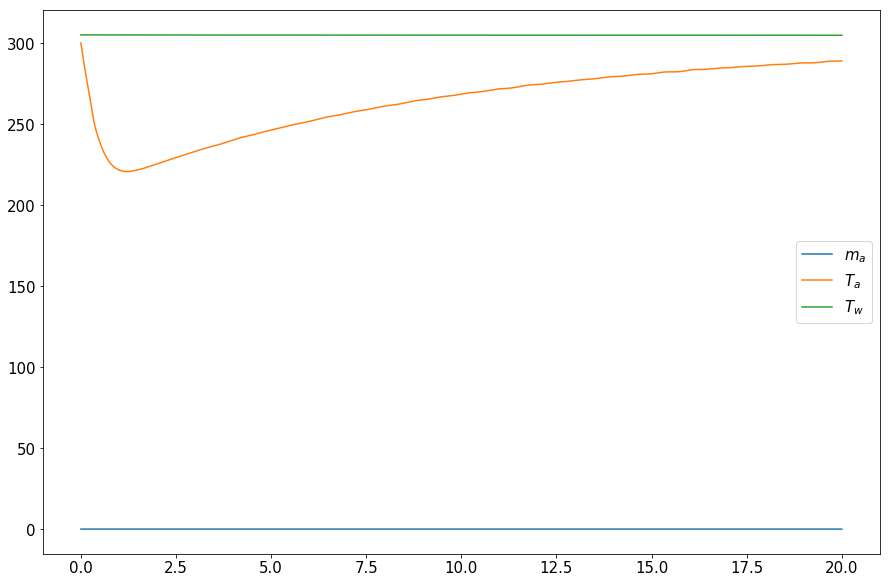

In [40]:
plt.plot(sol.t,sol.y[0],label="$m_a$")
plt.plot(sol.t,sol.y[1],label="$T_a$")
plt.plot(sol.t,sol.y[2],label="$T_w$")
plt.legend()
plt.show()

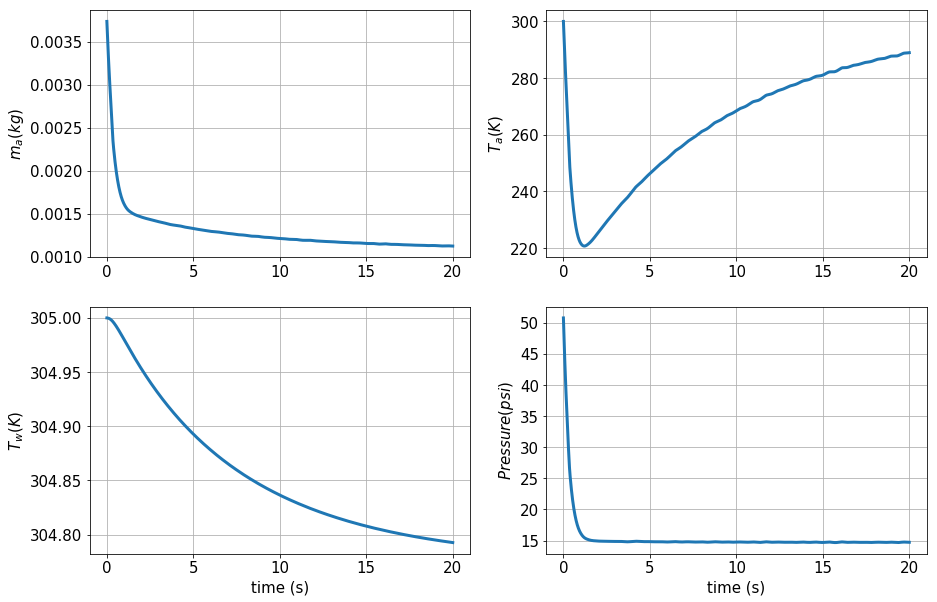

In [41]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 15})
plt.subplot(2,2,1)
plt.plot(sol.t, sol.y[0],linewidth = 3)
plt.ylabel("$m_a (kg)$")
plt.grid()
plt.subplot(2,2,2)
plt.ylabel("$T_a (K)$")
plt.plot(sol.t, sol.y[1],linewidth = 3)
plt.grid()
#plt.legend()
#plt.xlabel("time (s)")
plt.subplot(2,2,3)
plt.ylabel("$T_w (K)$")
plt.plot(sol.t, sol.y[2],linewidth = 3)
plt.grid()
#plt.legend()
plt.xlabel("time (s)")
plt.subplot(2,2,4)
plt.ylabel("$Pressure (psi)$")
plt.plot(sol.t, p_a(sol.y[0],R_a,sol.y[1],V)*0.000145038,linewidth = 3)
plt.grid()
#plt.legend()
plt.xlabel("time (s)")
plt.show()